<a href="https://www.kaggle.com/code/fiftythirtyfour/airline-delays?scriptVersionId=162559749" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
pd.options.display.max_columns = 100
import warnings
warnings.filterwarnings("ignore")

# Load
ref = pd.read_csv('/kaggle/input/flight-delays/airports.csv')
df = pd.read_csv('/kaggle/input/flight-delays/flights.csv'
    , dtype={'ORIGIN_AIRPORT': 'object'
             , 'DESTINATION_AIRPORT': 'object'
             , 'SCHEDULED_DEPARTURE': 'object'
             , 'SCHEDULED_ARRIVAL': 'object'
             , 'DEPARTURE_TIME': 'object'
             , 'ARRIVAL_TIME': 'object'
             , 'SCHEDULED_TIME': 'object'
             , 'ELAPSED_TIME': 'object'
             , 'AIR_TIME': 'object'
             , 'WHEELS_OFF': 'object'
             , 'WHEELS_ON': 'object'
             , 'TAXI_IN': 'object'
             , 'TAXI_OUT': 'object'})

# Clean
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df['otp_dep15'] = np.where(df['departure_delay'] <= 15, 1, 0)

## Cleaning Time
def convert_time(col):
    return pd.to_datetime(col, format='%H%M', errors='coerce').dt.time

tim = ['scheduled_departure', 'departure_time', 'taxi_out',
       'wheels_off', 'scheduled_time', 'elapsed_time', 'air_time',
       'wheels_on', 'taxi_in', 'scheduled_arrival', 'arrival_time']

for tt in tim:
    df[tt] = convert_time(df[tt])

# Organization
tim.append('date')
num = [x for x in df.columns if df.dtypes[x] in ('int64', 'float')]
cat = [x for x in df.columns if df.dtypes[x] == 'object' and x not in tim]
target = 'departure_delay'
num.remove(target)

# Summary Notes
## Version 02. Understanding the Target
It is important to understand the metric that we are trying to predict. It guides you through the forest of features. You need to obsess over the target as much as  possible and try to tame it by doing a lot of graphs.

What I know so far:
- Industry standard that departure OTP is within 15 mins. If a flight departures within 15 mins from its scheduled departure time, that is still considered on time and not delayed.
- We don't care if the plane departed early. If so, then it becomes a classification task? Or does it matter if we try to think of it as a regression? Do both and see. Start with a regression and understand if there are bundling involved. I would assume that there are delays that are short but happens often and that there are delays that are very long but are rare.
- There are uncontrollable events that causes delays. *“Knowing when your planes are going to take off and with high degree of confidence allows the airline to better manage maintenance, recover faster from weather and related delay events, and reduce delay.”*

## Version 01
My plan is to start looking at 1 airline to understand the data and find any anomalies. I choose to start with UA airline because it is in the middle of volume and seems to be consistent throughout the year.

There origin airport around October are not iata codes. They are random numbers which looks like placeholder for missing data. It is a pain. I think I should just focus on the first 3 months of the year as training data and use the 4th month as test data.

## Version 00
Merger of American Airlines and US Airways Merger happend around June 2015.


# Explore

## Flights by Airlines
Listed all the flights just to check the integrity of the data and saw some that US airline had only half a year worth of data.

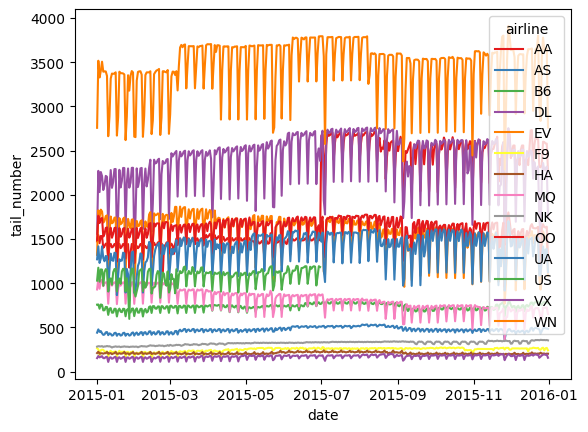

In [2]:
g = df.groupby(['date', 'airline'])['tail_number'].count().reset_index()
g = g
sns.lineplot(data=g, x='date', y='tail_number', hue='airline', palette='Set1');

## American Airlines and US Airways Merger
It turns out that in 2015, US Airways was acquired by American Airlines.

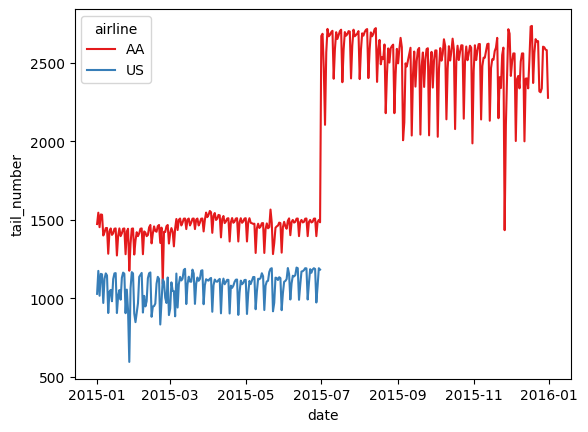

In [3]:
g = df.groupby(['date', 'airline'])['tail_number'].count().reset_index()
g = g.query('airline==["US", "AA"]')
sns.lineplot(data=g, x='date', y='tail_number', hue='airline', palette='Set1');

## Finding an Airline to start with
The above is interesting but I need to find an airline to work my magic and apply it to the rest to see the bigger picture. "UA" seems to be consistent throughout the year and I will start with that.

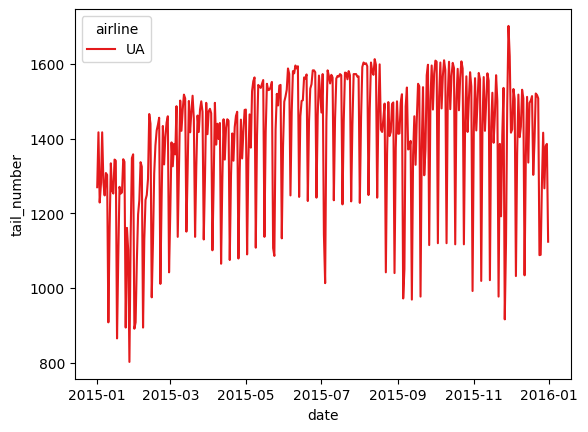

In [4]:
g = df.groupby(['date', 'airline'])['tail_number'].count().reset_index()
g = g.query('airline==["UA"]')
sns.lineplot(data=g, x='date', y='tail_number', hue='airline', palette='Set1');

## Break

In [5]:
df.groupby('airline')['otp_dep15'].describe()

,count,mean,std,min,25%,50%,75%,max
airline,,,,,,,,
AA,725984.0,0.821150,0.383227,0.0,1.0,1.0,1.0,1.0
AS,172521.0,0.892570,0.309661,0.0,1.0,1.0,1.0,1.0
B6,267048.0,0.775381,0.417332,0.0,1.0,1.0,1.0,1.0
DL,875881.0,0.860894,0.346057,0.0,1.0,1.0,1.0,1.0
EV,571977.0,0.809945,0.392345,0.0,1.0,1.0,1.0,1.0
F9,90836.0,0.772117,0.419469,0.0,1.0,1.0,1.0,1.0
HA,76272.0,0.929371,0.256205,0.0,1.0,1.0,1.0,1.0
MQ,294632.0,0.766074,0.423326,0.0,1.0,1.0,1.0,1.0
NK,117379.0,0.722557,0.447739,0.0,0.0,1.0,1.0,1.0


In [6]:
check = df.query('airline==["UA"]').copy()

<Axes: >

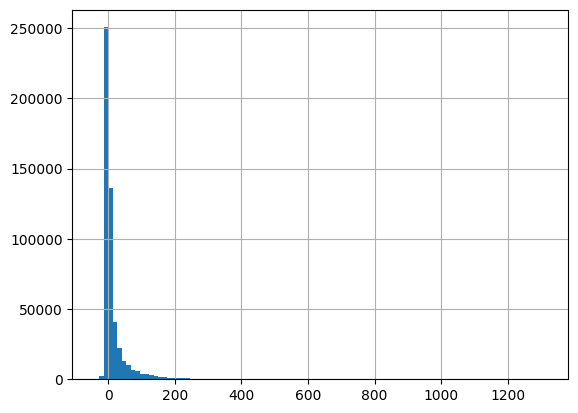

In [7]:
check[target].hist(bins=100)

In [8]:
check[target].describe()

count    509534.000000
mean         14.435441
std          42.055788
min         -40.000000
25%          -4.000000
50%           1.000000
75%          13.000000
max        1314.000000
Name: departure_delay, dtype: float64

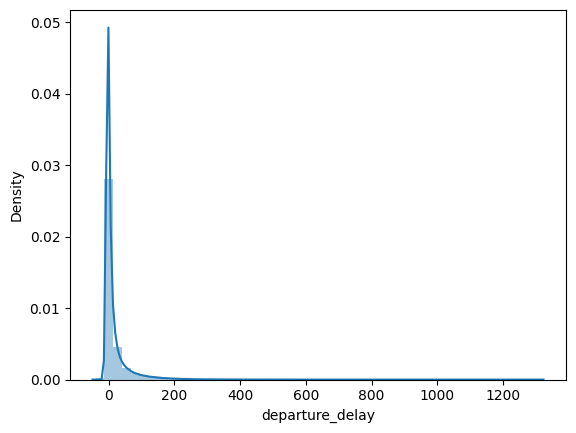

In [9]:
sns.distplot(check[target]);